# Requirements

In [1]:
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


# Libraries

In [2]:
# Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

# System Libraries
from pathlib import Path
import os
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
from PIL import Image, ImageChops, ImageEnhance

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Model
from tensorflow.keras.applications import MobileNetV2,ResNet50, ResNet50V2

# Extra
from termcolor import colored
#from google.colab import drive
import zipfile

# Data

### Directory

In [3]:
!ls "/kaggle/input/datasett"
dir = "/kaggle/input/dataset"

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ls: cannot access '/kaggle/input/datasett': No such file or directory


### Selecting the Models
In this experiments, we only use Stable Diffusion

In [4]:
# List of classes to include (everything except AI_SD)
allowed_classes = [
    'AI_SD_art_nouveau', 'AI_SD_baroque', 'AI_SD_expressionism', 'AI_SD_impressionism',
    'AI_SD_realism', 'AI_SD_renaissance', 'AI_SD_romanticism',
    'AI_SD_surrealism', 'AI_SD_ukiyo-e',
    'art_nouveau', 'surrealism', 'baroque', 'ukiyo_e', 'expressionism', 'impressionism',
    'realism', 'renaissance', 'romanticism'
]

def create_filtered_df(folder_path, max_images_per_class=1000):
    all_images = []
    for class_name in allowed_classes:
        class_path = os.path.join(folder_path, class_name)


        if os.path.exists(class_path):
            class_images = [(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)]

            all_images.extend(class_images[:max_images_per_class])

    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

dataset = create_filtered_df(dir)
dataset

file_path              label
0      /kaggle/input/dataset/AI_SD_art_nouveau/0-2339...  AI_SD_art_nouveau
1      /kaggle/input/dataset/AI_SD_art_nouveau/0-1612...  AI_SD_art_nouveau
2      /kaggle/input/dataset/AI_SD_art_nouveau/0-1594...  AI_SD_art_nouveau
3      /kaggle/input/dataset/AI_SD_art_nouveau/0-1696...  AI_SD_art_nouveau
4      /kaggle/input/dataset/AI_SD_art_nouveau/0-2165...  AI_SD_art_nouveau
...                                                  ...                ...
17995  /kaggle/input/dataset/romanticism/thomas-sully...        romanticism
17996  /kaggle/input/dataset/romanticism/karoly-lotz_...        romanticism
17997  /kaggle/input/dataset/romanticism/william-turn...        romanticism
17998  /kaggle/input/dataset/romanticism/miklos-barab...        romanticism
17999  /kaggle/input/dataset/romanticism/jan-matejko_...        romanticism

[18000 rows x 2 columns]

# Exploratory Data Analysis

### Data Distribution

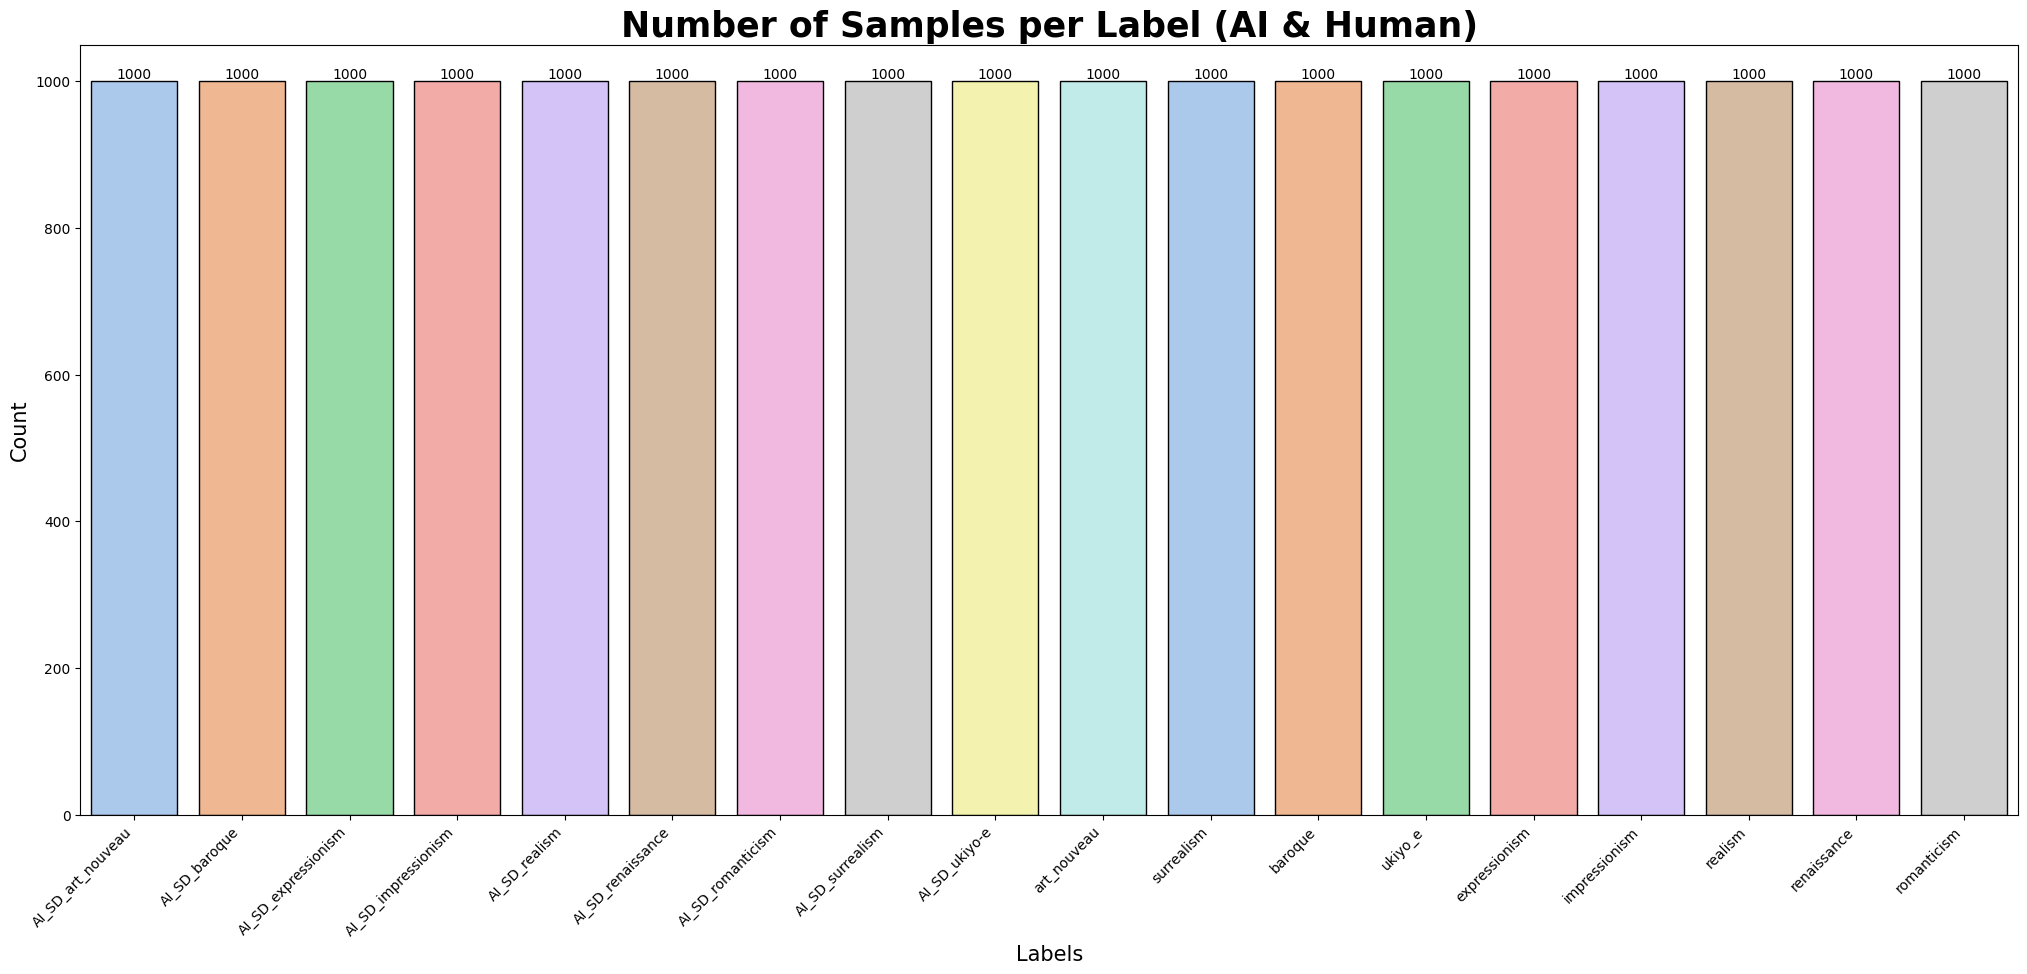

In [5]:
# Count the number of samples per label
label_counts = dataset['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']  # Rename columns for clarity

# Plotting
plt.figure(figsize=(25, 10))
ax = sns.barplot(data=label_counts, x='label', y='count', edgecolor='black', palette='pastel')

# Adding labels to the bars
for i in ax.containers:
    ax.bar_label(i)

# Set plot title and labels
plt.title('Number of Samples per Label (AI & Human)', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()


### Plot Random Image AI Generated & Human for each class

Available AI_LD classes:
['AI_SD_art_nouveau' 'AI_SD_baroque' 'AI_SD_expressionism'
 'AI_SD_impressionism' 'AI_SD_realism' 'AI_SD_renaissance'
 'AI_SD_romanticism' 'AI_SD_surrealism' 'AI_SD_ukiyo-e']

Available human classes:
['art_nouveau' 'surrealism' 'baroque' 'ukiyo_e' 'expressionism'
 'impressionism' 'realism' 'renaissance' 'romanticism']


/tmp/ipykernel_30/133573768.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ai_sd_images['base_class'] = ai_sd_images['label'].apply(get_base_class_name)
/tmp/ipykernel_30/133573768.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_images['base_class'] = human_images['label']  # Human images already have base class names
/tmp/ipykernel_30/133573768.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

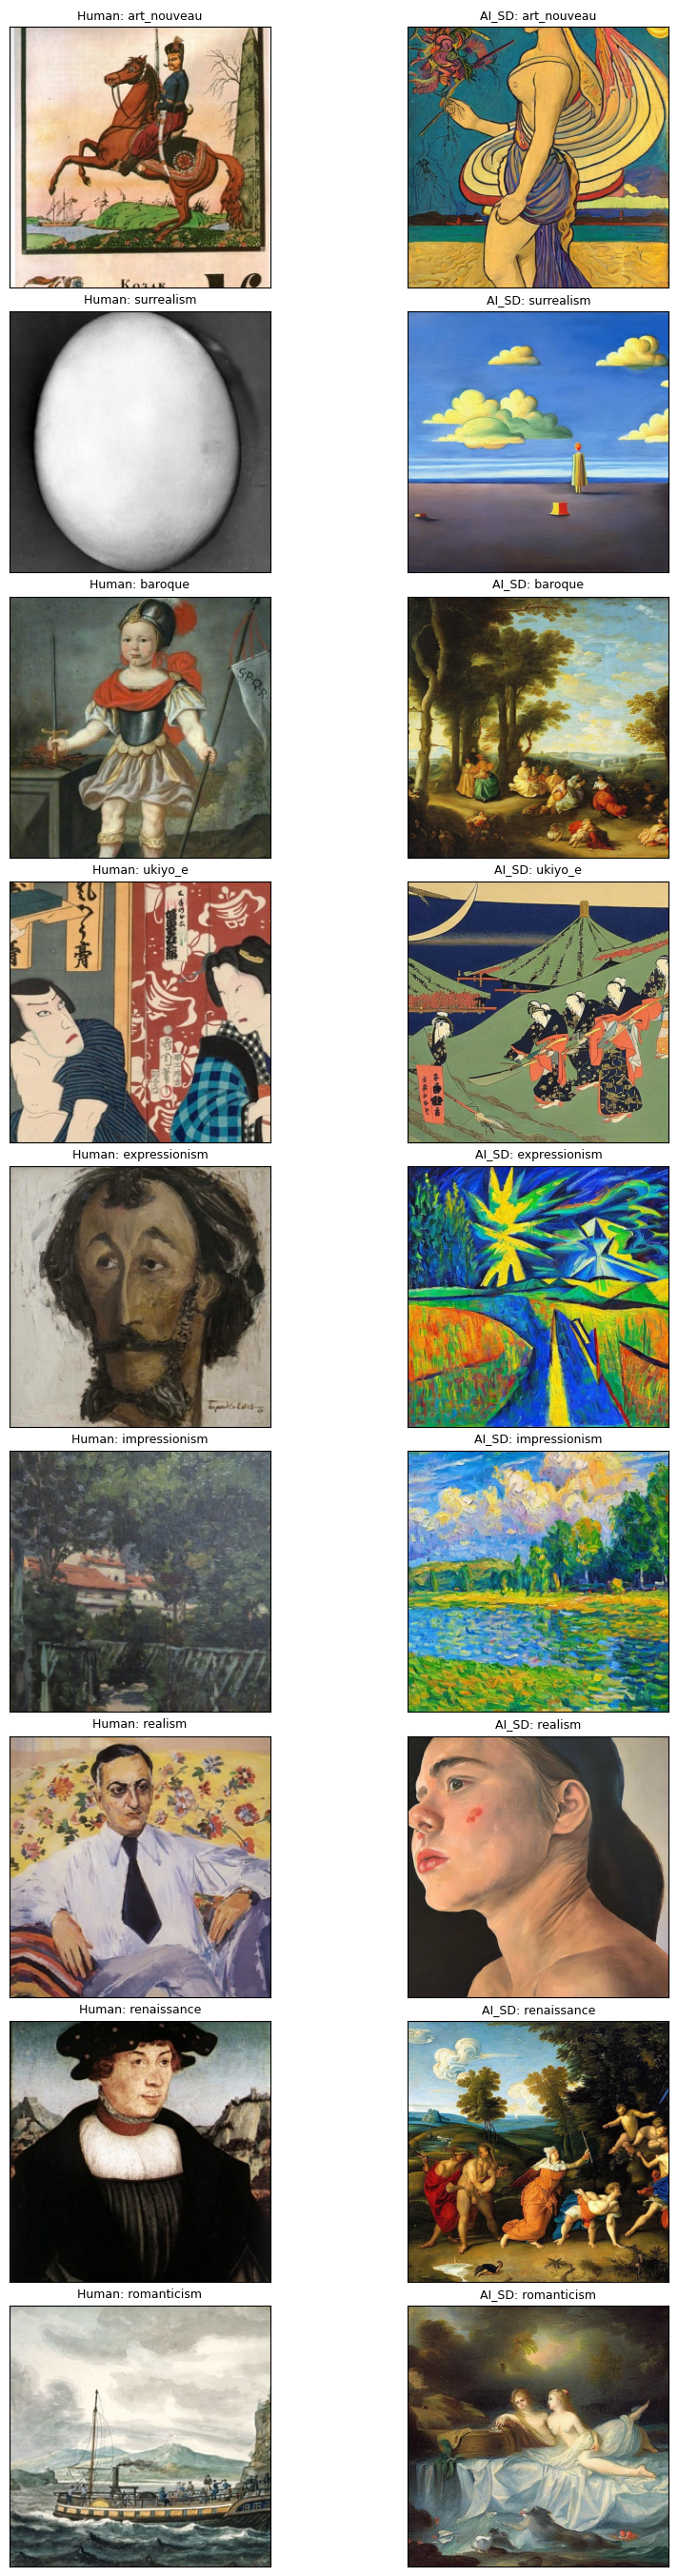

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Function to check if the label is an AI_LD label
def is_ai_sd(label):
    return 'AI_SD_' in label

# Function to remove the 'AI_LD_' prefix to get the base class name
def get_base_class_name(label):
    return label.replace('AI_SD_', '')

# Drop duplicates to get one sample per label
df_unique = dataset.copy().drop_duplicates(subset=['label']).reset_index()

# Split dataset into AI_LD images and human images (no AI_LD or AI_SD in label)
ai_sd_images = df_unique[df_unique['label'].apply(is_ai_sd)]
human_images = df_unique[~df_unique['label'].apply(lambda label: 'AI_LD_' in label or 'AI_SD_' in label)]

# Print available classes for debugging
print("Available AI_LD classes:")
print(ai_sd_images['label'].unique())
print("\nAvailable human classes:")
print(human_images['label'].unique())

# Create a base class name column for both human and AI_LD images
ai_sd_images['base_class'] = ai_sd_images['label'].apply(get_base_class_name)
human_images['base_class'] = human_images['label']  # Human images already have base class names
ai_sd_images['base_class'] = ai_sd_images['base_class'].replace('ukiyo-e', 'ukiyo_e')

# Merge AI_LD and human images on the base class name
paired_classes = pd.merge(human_images, ai_sd_images, on='base_class', suffixes=('_human', '_ai_sd'), how='inner')

# Check if we have valid pairs
if paired_classes.empty:
    print("No matching AI_LD and Human pairs found.")
else:
    # Number of paired classes
    num_classes = len(paired_classes)

    # Create the plot with 2 images (human and AI_LD) per row for each class
    fig, axes = plt.subplots(num_classes, 2, figsize=(10, num_classes * 3),
                             subplot_kw={'xticks': [], 'yticks': []})

    # Plot images side by side for each class (human and AI_LD)
    for i in range(num_classes):
        # Human image
        axes[i, 0].imshow(plt.imread(paired_classes.file_path_human[i]))
        axes[i, 0].set_title(f"Human: {paired_classes.base_class[i]}", fontsize=9)

        # AI_LD image
        axes[i, 1].imshow(plt.imread(paired_classes.file_path_ai_sd[i]))
        axes[i, 1].set_title(f"AI_SD: {paired_classes.base_class[i]}", fontsize=9)

    # Adjust layout
    plt.tight_layout(pad=0.5)
    plt.show()


# Data Preprocessing

### Splitting Training and Testing data

In [7]:
train, test = train_test_split(dataset, test_size = 0.2, random_state = 0)
val, test = train_test_split(test, test_size = 0.5, random_state = 0)

### Target Size & Batch Size

In [8]:
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

### Augmentation

#### Train

In [9]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    shear_range = 0.1,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_dataframe(
  dataframe = train,
  x_col = 'file_path',
  y_col = 'label',
  target_size = TARGET_SIZE,
  color_mode = 'rgb',
  class_mode = 'categorical',
  batch_size = BATCH_SIZE,
  shuffle = True,
  seed = 42
)

Found 14400 validated image filenames belonging to 18 classes.


#### Validation

In [10]:
#Validation Generator
val_datagen = ImageDataGenerator(rescale=1./255,)

val_generator = val_datagen.flow_from_dataframe(
  dataframe = val,
  x_col = 'file_path',
  y_col = 'label',
  target_size = TARGET_SIZE,
  color_mode = 'rgb',
  class_mode = 'categorical',
  batch_size = BATCH_SIZE,
  shuffle = False,
  seed = 42
)

Found 1800 validated image filenames belonging to 18 classes.


#### Testing

In [11]:
test_datagen = ImageDataGenerator(rescale=1. / 255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    x_col = 'file_path',
    y_col = 'label',
    target_size = TARGET_SIZE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    seed = 42,
    shuffle = False
)

Found 1800 validated image filenames belonging to 18 classes.


# Modeling

### Model

In [12]:
base_model = ResNet50V2(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

# Build the model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())  # Global Average Pooling layer

# Add a Dense layer with L2 regularization
model.add(layers.Dense(512, activation='relu'))

# Add a Dropout layer for regularization
model.add(layers.Dropout(0.5))

# Output layer (binary classification, hence the sigmoid activation)
model.add(layers.Dense(18, activation='softmax'))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Callbacks

In [13]:
# Model Checkpoint
checkpoint_cb = ModelCheckpoint('MyModel.weights.h5', save_best_only=True, save_weights_only=True, save_freq='epoch')

# Early Stopping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLRonPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [14]:
model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

# Train & Evaluation

### Training

In [15]:
history = model.fit(
    train_generator,
    epochs = 50,
    validation_data = val_generator,
    callbacks = [checkpoint_cb, earlystop_cb, reduce_lr],
    batch_size = 32
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728986025.130267     119 service.cc:145] XLA service 0x78fb28014950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728986025.130319     119 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/450 ━━━━━━━━━━━━━━━━━━━━ 7:12:03 58s/step - accuracy: 0.1250 - loss: 3.0267

I0000 00:00:1728986051.224027     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


450/450 ━━━━━━━━━━━━━━━━━━━━ 337s 623ms/step - accuracy: 0.4034 - loss: 1.8592 - val_accuracy: 0.2489 - val_loss: 5.1359 - learning_rate: 0.0010
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 197s 432ms/step - accuracy: 0.5635 - loss: 1.2297 - val_accuracy: 0.5000 - val_loss: 1.5844 - learning_rate: 0.0010
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 197s 431ms/step - accuracy: 0.6141 - loss: 1.0927 - val_accuracy: 0.5344 - val_loss: 1.3463 - learning_rate: 0.0010
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 195s 427ms/step - accuracy: 0.6319 - loss: 1.0321 - val_accuracy: 0.5050 - val_loss: 1.8591 - learning_rate: 0.0010
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 195s 426ms/step - accuracy: 0.6572 - loss: 0.9613 - val_accuracy: 0.2428 - val_loss: 5.6469 - learning_rate: 0.0010
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 194s 424ms/step - accuracy: 0.6669 - loss: 0.9328 - val_accuracy: 0.3717 - val_loss: 3.5355 - learning_rate: 0.0010
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 195s 426ms/step - accuracy: 0.6949 

### Model Evaluation

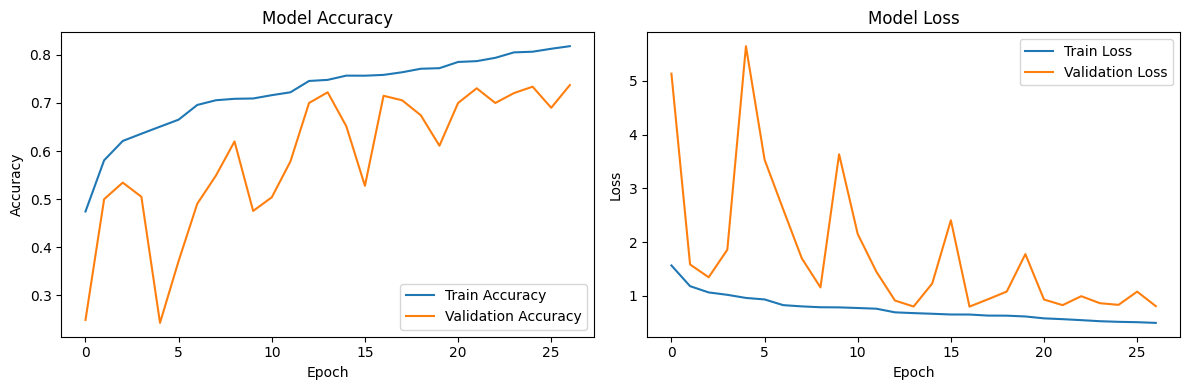

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [17]:
model.evaluate(test_generator)

57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 292ms/step - accuracy: 0.7280 - loss: 0.7656


[0.8033775091171265, 0.7188888788223267]

57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step


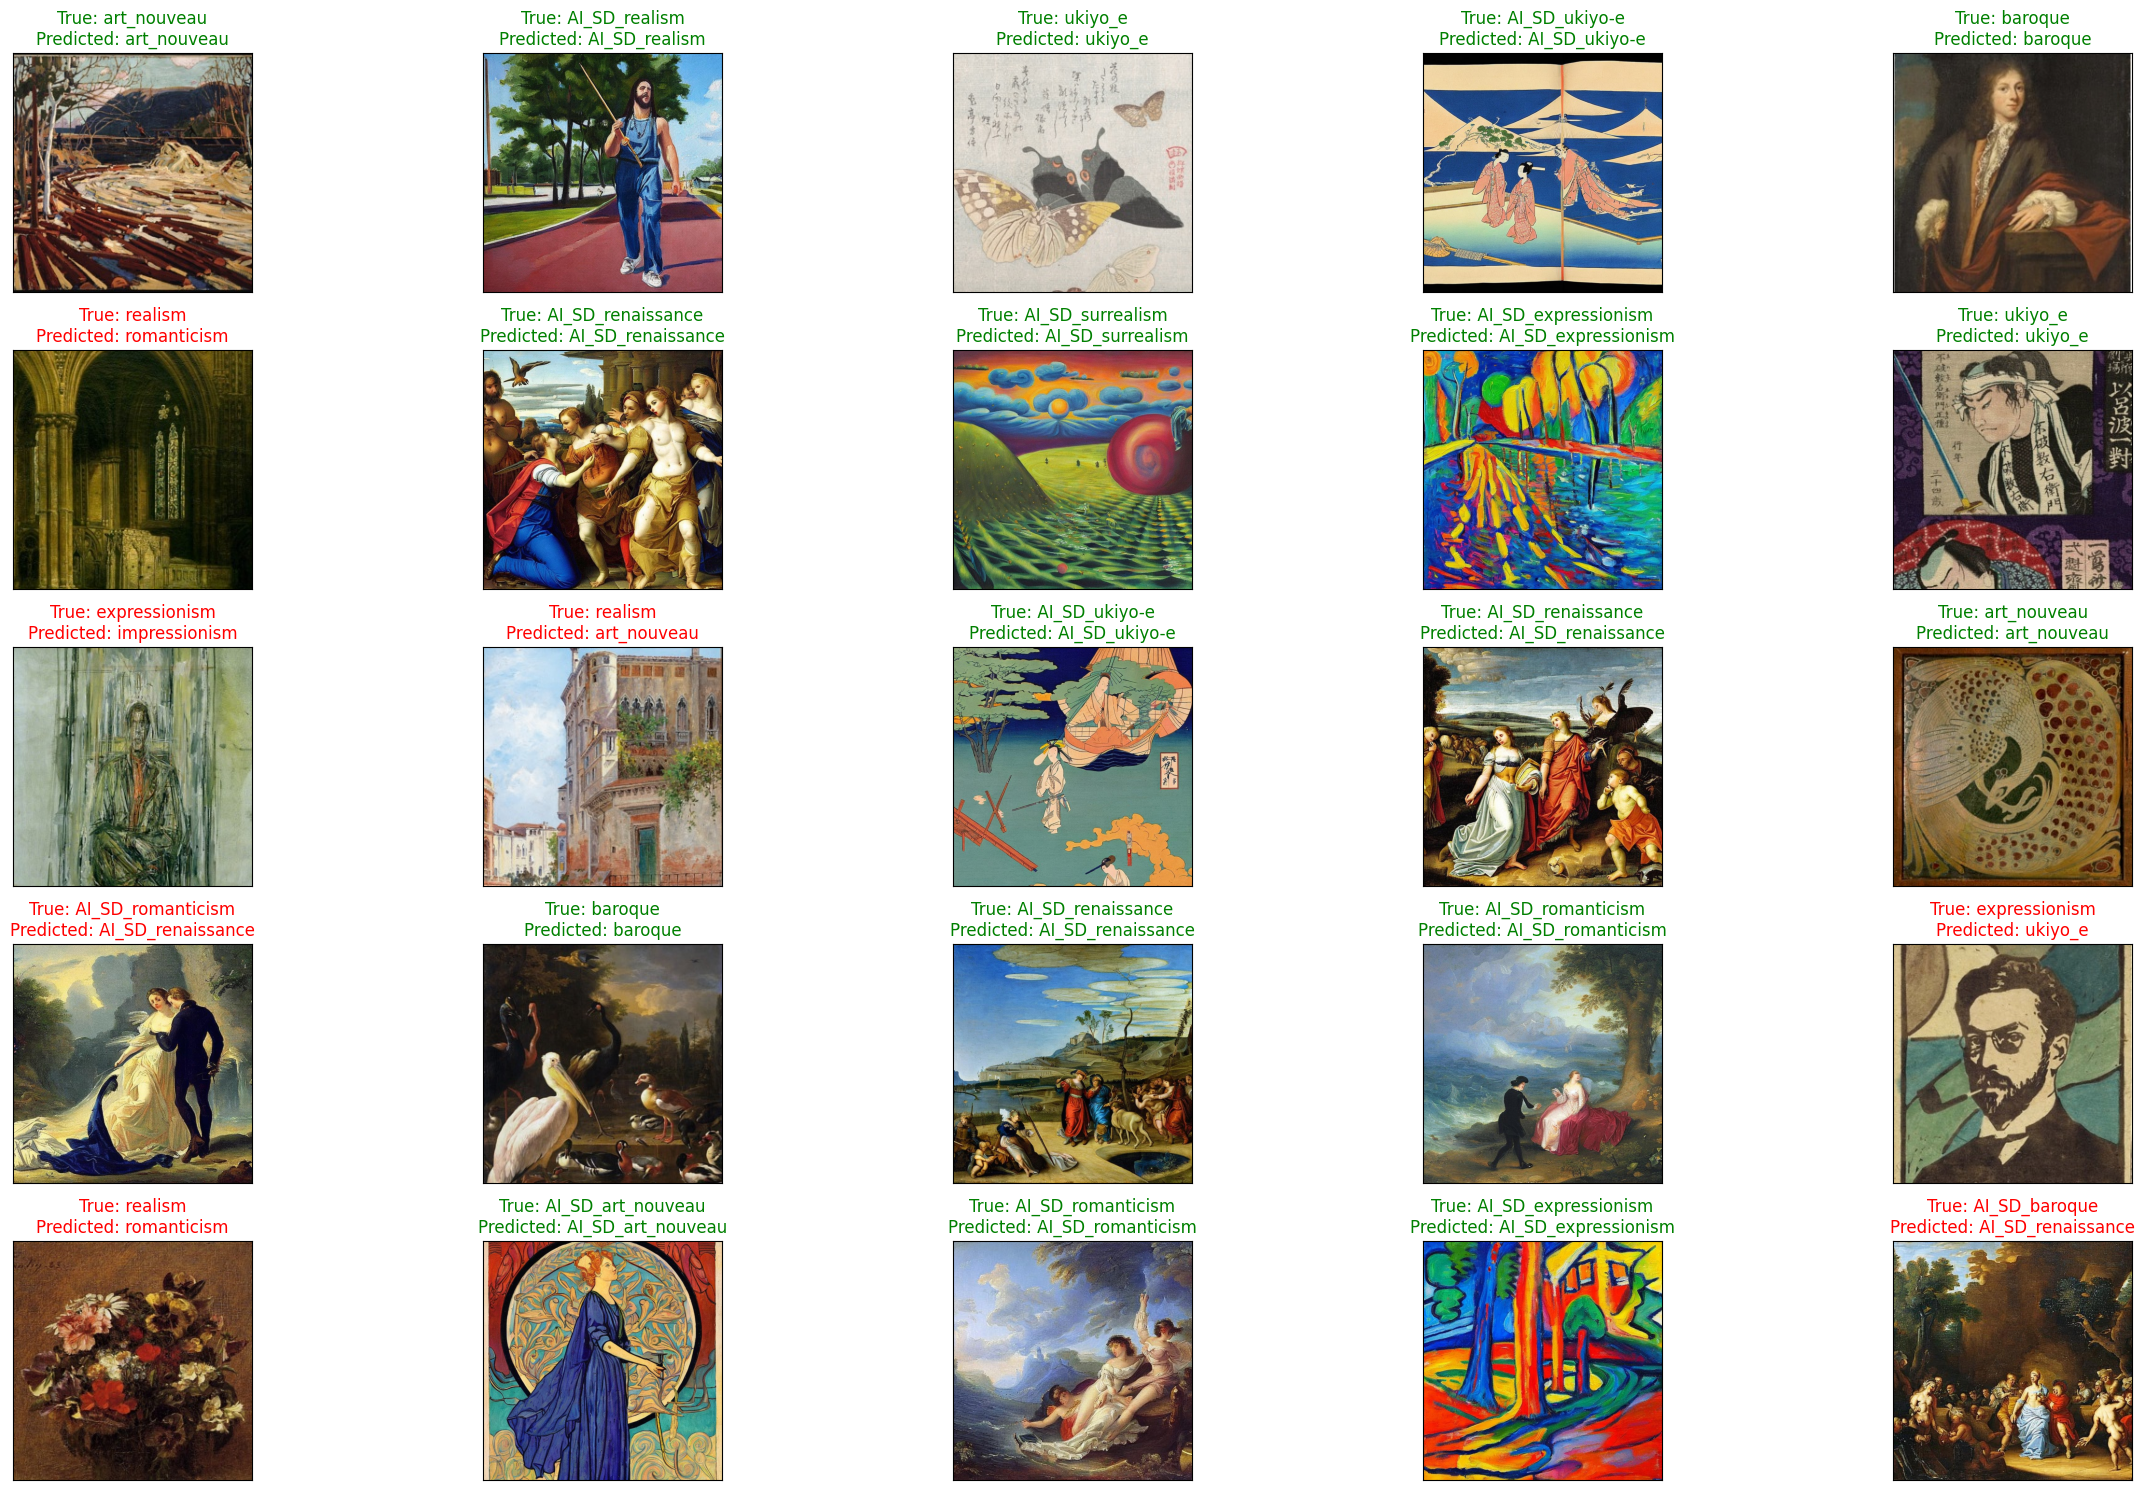

In [18]:
num_images = len(test)  # Assuming `test_dataset` is a pandas DataFrame with the test data

class_labels = list(train_generator.class_indices.keys())

# Getting all the true labels for the validation set
true_labels = test_generator.classes

# To get the predicted labels, we predict using the model
predictions = model.predict(test_generator, steps=len(test_generator))

# Take the argmax to get the predicted class indices.
predicted_labels = np.argmax(predictions, axis=1)

random_index = np.random.randint(0, len(test) - 1, num_images)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 15),
                             subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
        # Replace 'file_path' and 'class_label' with the correct column names for image paths and labels
        img_path = test['file_path'].iloc[random_index[i]]
        true_label = test['label'].iloc[random_index[i]]

        # Get the predicted class index and map it to the class name
        pred_index = predicted_labels[random_index[i]]
        pred_label = class_labels[pred_index]  # Convert the index to the class name

        # Display the image
        ax.imshow(plt.imread(img_path))

        # Determine the color of the title based on prediction accuracy
        if true_label == pred_label:
            color = "green"
        else:
            color = "red"

        # Set title showing true and predicted class names
        ax.set_title(f"True: {true_label}\nPredicted: {pred_label}", color=color)

plt.tight_layout()
plt.show()

# Plot Random Images from Test

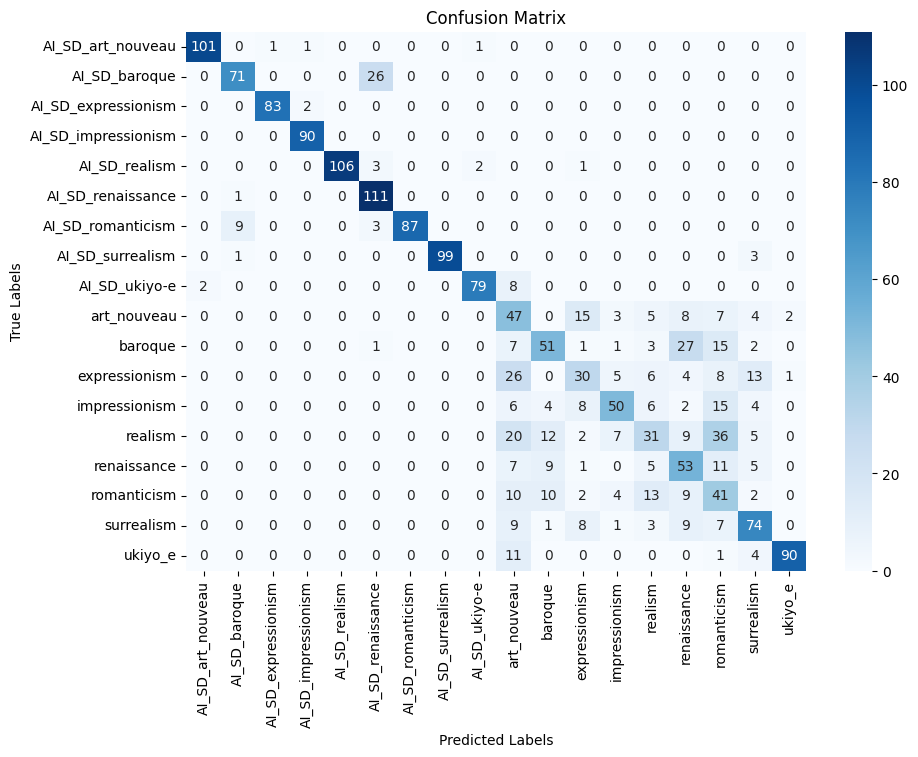

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Getting all the true labels for the test set (already given in your code)
true_labels = test_generator.classes

# Predicted labels from the model (already given in your code)
predicted_labels = np.argmax(predictions, axis=1)

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get class labels from the test generator or manually set them
class_names = list(train_generator.class_indices.keys())  # Ensure this is the correct order

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
